In [3]:
import numpy as np
import matplotlib.pyplot as plt

Newton iterations: 10
BFGS iterations:   20
Final f (Newton): 3.533e-10
Final f (BFGS):   5.578e-10


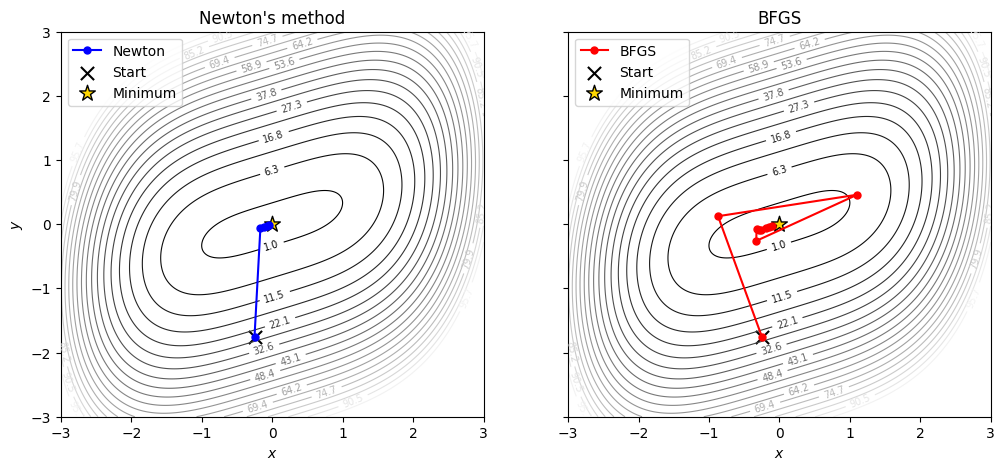

In [5]:
# ---------------------------------------------------
# Objective: f(x, y) = (x - 3y)^2 + x^4
# ---------------------------------------------------
def f(x):
    x1, x2 = x
    return (x1 - 3.0 * x2)**2 + x1**4

def grad_f(x):
    x1, x2 = x
    df_dx1 = 2.0 * (x1 - 3.0 * x2) + 4.0 * x1**3
    df_dx2 = -6.0 * (x1 - 3.0 * x2)
    return np.array([df_dx1, df_dx2])

def hess_f(x):
    x1, x2 = x
    d2f_dx1dx1 = 2.0 + 12.0 * x1**2
    d2f_dx1dx2 = -6.0
    d2f_dx2dx2 = 18.0
    return np.array([[d2f_dx1dx1, d2f_dx1dx2],
                     [d2f_dx1dx2, d2f_dx2dx2]])

# ---------------------------------------------------
# Armijo backtracking line search (for BFGS)
# ---------------------------------------------------
def backtracking_line_search(x, p, g, alpha0=1.0, rho=0.5, c=1e-4):
    fx = f(x)
    gTp = g.dot(p)
    alpha = alpha0
    while f(x + alpha * p) > fx + c * alpha * gTp:
        alpha *= rho
        if alpha < 1e-8:
            break
    return alpha

# ---------------------------------------------------
# Newton's method 
# ---------------------------------------------------
def newton_method(x0, max_iter=100, tol=1e-6):
    x = x0.copy()
    path = [x.copy()]
    for k in range(max_iter):
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        H = hess_f(x)
        try:
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            p = -g
        x = x + p
        path.append(x.copy())
    return np.array(path)

# ---------------------------------------------------
# BFGS (quasi-Newton) with line search
# ---------------------------------------------------
def bfgs(x0, max_iter=100, tol=1e-6):
    x = x0.copy()
    n = len(x0)
    H_inv = np.eye(n)
    g = grad_f(x)
    path = [x.copy()]

    for k in range(max_iter):
        if np.linalg.norm(g) < tol:
            break

        p = -H_inv.dot(g)
        alpha = backtracking_line_search(x, p, g)
        s = alpha * p
        x_new = x + s
        g_new = grad_f(x_new)
        y = g_new - g

        ys = y.dot(s)
        if ys > 1e-10:
            rho = 1.0 / ys
            I = np.eye(n)
            V = I - rho * np.outer(s, y)
            H_inv = V.dot(H_inv).dot(V.T) + rho * np.outer(s, s)

        x, g = x_new, g_new
        path.append(x.copy())

    return np.array(path)

# ---------------------------------------------------
# Run both methods from the same starting point
# ---------------------------------------------------
x0 = np.array([-0.25, -1.75])   
path_newton = newton_method(x0)
path_bfgs   = bfgs(x0)

print(f"Newton iterations: {len(path_newton) - 1}")
print(f"BFGS iterations:   {len(path_bfgs)   - 1}")
print(f"Final f (Newton): {f(path_newton[-1]):.3e}")
print(f"Final f (BFGS):   {f(path_bfgs[-1]):.3e}")

# For visualization: only first K steps (keeps plot clean)
K_newton = min(5, len(path_newton))
K_bfgs   = min(10, len(path_bfgs))
pn = path_newton[:K_newton]
pb = path_bfgs[:K_bfgs]

# ---------------------------------------------------
# Prepare contour grid (same for both subplots)
# ---------------------------------------------------
x1 = np.linspace(-3.0, 3.0, 400)
x2 = np.linspace(-3.0, 3.0, 400)
X1, X2 = np.meshgrid(x1, x2)
Z = (X1 - 3.0 * X2)**2 + X1**4
levels = np.linspace(1, 101.0, 20)
#levels = [0.2, 1, 5, 10, 20, 40, 80, 120]

# ---------------------------------------------------
# Side-by-side plots
# ---------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# --- Left: Newton ---
ax = axes[0]
cs = ax.contour(X1, X2, Z, levels=levels, linewidths=0.8, cmap='gray')
ax.clabel(cs, inline=1, fontsize=7, fmt="%.1f")
ax.plot(pn[:, 0], pn[:, 1], "o-", markersize=5, color='blue', label="Newton")
ax.scatter(x0[0], x0[1], marker="x", s=90, color="black", label="Start")
ax.scatter(0.0, 0.0, marker="*", s=140, color="gold", edgecolor="black", label="Minimum")
ax.set_title("Newton's method")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.legend()

# --- Right: BFGS ---
ax = axes[1]
cs = ax.contour(X1, X2, Z, levels=levels, linewidths=0.8, cmap='gray')
ax.clabel(cs, inline=1, fontsize=7, fmt="%.1f")
ax.plot(pb[:, 0], pb[:, 1], "o-", markersize=5, color='red', label="BFGS")
ax.scatter(x0[0], x0[1], marker="x", s=90, color="black", label="Start")
ax.scatter(0.0, 0.0, marker="*", s=140, color="gold", edgecolor="black", label="Minimum")
ax.set_title("BFGS")
ax.set_xlabel(r"$x$")
ax.legend()
plt.savefig('figures/bfgs.pdf', bbox_inches='tight')